In [3]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from scipy.stats import mannwhitneyu

# helpfunctions

In [4]:
def dependency_matrix_tree_ver_1(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

In [5]:
def dependency_matrix_tree_ver_2(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1 / np.exp(depth)
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1 / np.exp(depth)
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

In [6]:
def dependency_matrix_forest(model, n_features):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_1(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

In [7]:
def dependency_matrix_forest_2(model, n_features):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_2(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

In [8]:
def Visualise_classification_2D(X, y):
  cols = ['blue', 'red', 'green', 'yellow']
  plt.figure(figsize=(9,4))
  plt.xlim((np.min(X) - 0.5, np.max(X) + 0.5)),
  plt.ylim((np.min(X) - 0.5, np.max(X) + 0.5))

  for k in np.unique(y):
      plt.plot(X[y==k,0], X[y==k,1], 'o',
                label='класс {}'.format(k), color=cols[k])

  plt.legend(loc='best')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

def Visualise_regression_2D(X, y, xlim, ylim):
  plt.figure(figsize=[9, 4])
  plt.xlim((xlim[0], xlim[1]))
  plt.ylim((ylim[0], ylim[1]))

  sc = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

  plt.colorbar(sc)

  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

In [20]:
def func_reg(X, y, alpha):
  params = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'n_estimators': [5000]}
  clf = GridSearchCV(MyRandomForestRegressor(random_state=0,
                                              n_estimators=params['n_estimators'],
                                              max_depth=params['max_depth'],
                                              max_leaf_nodes=2**max(params['max_depth']),
                                              bootstrap=True,
                                              oob_score=True,
                                              subforest_importance=True,
                                              normalize_importance=False,
                                              rit_alpha=alpha),
                   params,
                   scoring = lambda est, X, y: est.oob_score_, 
                   cv=[(np.arange(X.shape[0]), np.arange(0))])
  clf.fit(X, y)
  rf = clf.best_estimator_
  print("rit_alpha = {}, max_depth = {}, score = {}".format(rf.rit_alpha, rf.max_depth, rf.oob_score_))
  return rf


def func_class(X, y, alpha):
  params = {'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15], 'n_estimators': [5000]}
  clf = GridSearchCV(MyRandomForestClassifier(random_state=0,
                                              n_estimators=params['n_estimators'],
                                              max_depth=params['max_depth'],
                                              max_leaf_nodes=2**max(params['max_depth']),
                                              bootstrap=True,
                                              oob_score=accuracy_score,
                                              subforest_importance=True,
                                              normalize_importance=False,
                                              rit_alpha=alpha),
                   params,
                   scoring = lambda est, X, y: est.oob_score_, 
                   cv=[(np.arange(X.shape[0]), np.arange(0))])
  clf.fit(X, y)
  rf = clf.best_estimator_
  print("rit_alpha = {}, max_depth = {}, score = {}".format(rf.rit_alpha, rf.max_depth, rf.oob_score_))
  return rf

In [10]:
from graphviz import Digraph

def export_tree_to_dot(clf, feature_names=None):
    dot = Digraph()
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    values = clf.tree_.value

    # Генерируем цветовую палитру для фичей
    unique_features = np.unique(feature[feature >= 0])
    custom_colors = ["#FF6B6B", "#4ECDC4", "#45B7D1", "#96CEB4", "#FFEEAD"]
    feature_colors = {f: custom_colors[i % len(custom_colors)] 
                 for i, f in enumerate(unique_features)}

    # Добавляем легенду
    with dot.subgraph(name='legend') as legend:
        legend.attr(label='Legend', rank='sink')
        for f, color in feature_colors.items():
            feature_label = feature_names[f] if feature_names else f"Feature {f}"
            legend.node(f"legend_{f}", 
                        label=feature_label, 
                        shape="box", 
                        fillcolor=color, 
                        style="filled")

    # Создаем узлы
    for node_id in range(n_nodes):
        if children_left[node_id] == children_right[node_id]:
            # Листовой узел (серый цвет)
            class_label = np.argmax(values[node_id][0])
            label = f"Class {class_label}"
            dot.node(str(node_id), 
                    label=label, 
                    shape="box", 
                    style="filled", 
                    fillcolor="lightgray")
        else:
            # Разделяющий узел (цвет по фиче)
            f = feature[node_id]
            feature_label = feature_names[f] if feature_names else f"X[{f}]"
            label = f"{feature_label} <= {threshold[node_id]:.3f}"
            dot.node(str(node_id), 
                    label=label, 
                    shape="ellipse", 
                    style="filled", 
                    fillcolor=feature_colors[f])

    # Создаем связи
    for node_id in range(n_nodes):
        if children_left[node_id] != children_right[node_id]:
            dot.edge(str(node_id), str(children_left[node_id]), label="True")
            dot.edge(str(node_id), str(children_right[node_id]), label="False")

    return dot


In [11]:
def create_tree_view(tree, name):
    dot = export_tree_to_dot(tree, feature_names=["X1", "X2"])
    dot.render(name, view=True, format='png')

# Выборки

In [12]:
def data_regression_2D_1():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [13]:
def data_regression_2D_2():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 * X2 + np.random.random(N)/5
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

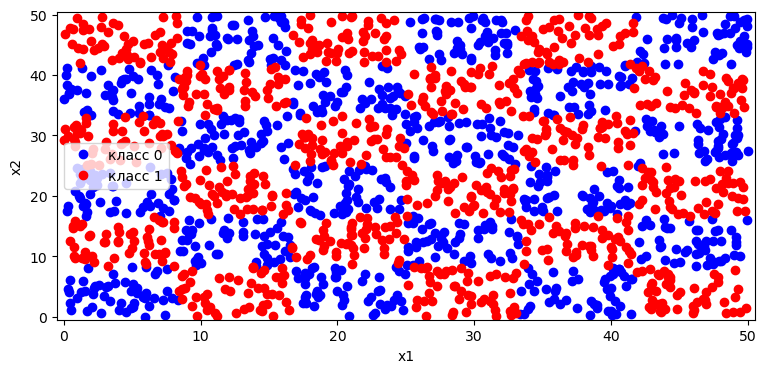

In [14]:
def data_classification_2D_3():
    n = 2
    l = 2000

  # Параметры
    width = 50         # Ширина прямоугольника
    height = 50        # Высота прямоугольника
    cols = 6         # Количество столбцов сетки
    rows = 6          # Количество строк сетки
    points_per_cell = 50  # Количество точек в каждой ячейке

    # Вычисление размеров ячейки
    cell_width = width / cols
    cell_height = height / rows

    # Генерация данных
    X = []
    y = []

    for i in range(cols):
        for j in range(rows):
            # Генерация координат точек внутри ячейки (i, j)
            x_points = np.random.uniform(i * cell_width, (i + 1) * cell_width, points_per_cell)
            y_points = np.random.uniform(j * cell_height, (j + 1) * cell_height, points_per_cell)
            
            # Определение класса (шахматный порядок)
            class_label = (i + j) % 2
            
            # Сохранение данных
            X.extend(np.column_stack((x_points, y_points)))
            y.extend([class_label] * points_per_cell)

    X = np.array(X)
    y = np.array(y)

    return X, y

X, y = data_classification_2D_3()
Visualise_classification_2D(X, y)

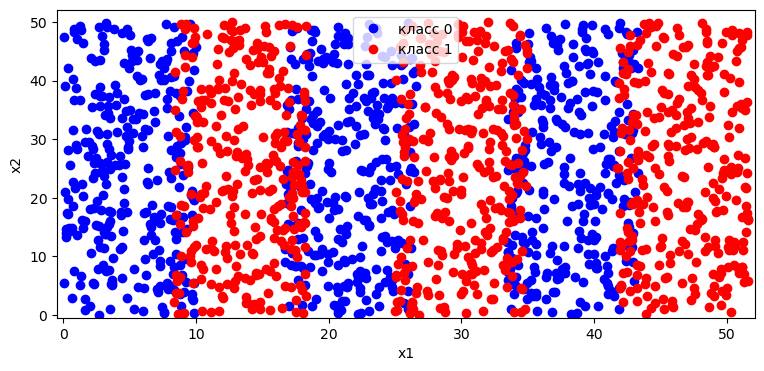

In [15]:
def data_classification_2D_4():
    n = 2
    l = 2000

    # Параметры
    width = 50        # Ширина прямоугольника
    height = 50         # Высота прямоугольника
    cols = 6           # Количество столбцов
    rows = 6           # Количество строк
    points_per_cell = 50  # Количество точек в каждой ячейке

    # Размеры ячейки
    cell_width = width / cols
    cell_height = height / rows

    # Генерация данных
    X = []
    y = []

    for i in range(cols):
        for j in range(rows):
            # Генерация случайных точек внутри ячейки (i, j)
            x_points = np.random.uniform(i * cell_width, (i + 1.2) * cell_width, points_per_cell)
            y_points = np.random.uniform(j * cell_height, (j + 1) * cell_height, points_per_cell)
            
            # Класс определяется только номером столбца (i)
            class_label = i % 2  # Четные столбцы — 0, нечетные — 1
            
            X.extend(np.column_stack((x_points, y_points)))
            y.extend([class_label] * points_per_cell)

    X = np.array(X)
    y = np.array(y)

    return X, y

X, y = data_classification_2D_4()
Visualise_classification_2D(X, y)

In [16]:
def data_regression_2D_5():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 + X2 + np.random.random(N)/300
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

In [17]:
def data_regression_2D_6():
  n = 2
  N = 2000

  X1 = np.random.random(N)
  X2 = np.random.random(N)

  y = X1 * X2 + np.random.random(N)/500
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

# Проверка деревьев

Сначала получим массив оттюненых моделей для различгых rit_alpha. Нужно 4 массива для 2х регрессий и 2х классификаций.

In [9]:
# 1
X, y = data_regression_2D_1()
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_1 = []
for alpha in alphas[:-1]:
    arr_1.append(func_reg(X, y, alpha))

rit_alpha = -10000, max_depth = 7, score = 0.9413066735893705
rit_alpha = 0, max_depth = 7, score = 0.9413066735893705
rit_alpha = 0.1, max_depth = 7, score = 0.941317305572063
rit_alpha = 0.2, max_depth = 7, score = 0.9412852496076275
rit_alpha = 0.3, max_depth = 7, score = 0.9412469876887203
rit_alpha = 0.5, max_depth = 7, score = 0.9410568892202249
rit_alpha = 0.7, max_depth = 7, score = 0.939859331783054
rit_alpha = 0.8, max_depth = 7, score = 0.9379205273409181
rit_alpha = 0.9, max_depth = 7, score = 0.9308284186303054
rit_alpha = 0.91, max_depth = 8, score = 0.9283063606714375
rit_alpha = 0.93, max_depth = 8, score = 0.918912960473693
rit_alpha = 0.95, max_depth = 8, score = 0.8977558526877535
rit_alpha = 0.99, max_depth = 5, score = 0.697132851536634
rit_alpha = 0.999, max_depth = 3, score = 0.6961543858984334


In [10]:
# 2
X, y = data_regression_2D_2()
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_2 = []
for alpha in alphas[:-1]:
    arr_2.append(func_reg(X, y, alpha))

rit_alpha = -10000, max_depth = 6, score = 0.9317747310395251
rit_alpha = 0, max_depth = 6, score = 0.9317747310395251
rit_alpha = 0.1, max_depth = 6, score = 0.9318023907537434
rit_alpha = 0.2, max_depth = 6, score = 0.931832880028353
rit_alpha = 0.3, max_depth = 6, score = 0.9318662518769271
rit_alpha = 0.5, max_depth = 6, score = 0.9319171171230192
rit_alpha = 0.7, max_depth = 7, score = 0.9316019176271138
rit_alpha = 0.8, max_depth = 7, score = 0.9310633901855383
rit_alpha = 0.9, max_depth = 7, score = 0.9299508088185858
rit_alpha = 0.91, max_depth = 7, score = 0.9294194019510678
rit_alpha = 0.93, max_depth = 8, score = 0.9252713977227384
rit_alpha = 0.95, max_depth = 8, score = 0.9070227118709623
rit_alpha = 0.99, max_depth = 6, score = 0.5901355542163432
rit_alpha = 0.999, max_depth = 3, score = 0.5820516591844622


In [11]:
# 3
X, y = data_classification_2D_3()
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_3 = []
for alpha in alphas[:-1]:
    arr_3.append(func_class(X, y, alpha))

rit_alpha = -10000, max_depth = 15, score = 0.9433333333333334
rit_alpha = 0, max_depth = 15, score = 0.9744444444444444
rit_alpha = 0.1, max_depth = 15, score = 0.9627777777777777
rit_alpha = 0.2, max_depth = 15, score = 0.9611111111111111
rit_alpha = 0.3, max_depth = 15, score = 0.9588888888888889
rit_alpha = 0.5, max_depth = 15, score = 0.9527777777777777
rit_alpha = 0.7, max_depth = 15, score = 0.8927777777777778
rit_alpha = 0.8, max_depth = 15, score = 0.7222222222222222
rit_alpha = 0.9, max_depth = 15, score = 0.5227777777777778
rit_alpha = 0.91, max_depth = 15, score = 0.5094444444444445
rit_alpha = 0.93, max_depth = 15, score = 0.49166666666666664
rit_alpha = 0.95, max_depth = 15, score = 0.48444444444444446
rit_alpha = 0.99, max_depth = 15, score = 0.4822222222222222
rit_alpha = 0.999, max_depth = 15, score = 0.4822222222222222


In [12]:
# 4
X, y = data_classification_2D_4()
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_4 = []
for alpha in alphas[:-1]:
    arr_4.append(func_class(X, y, alpha))

rit_alpha = -10000, max_depth = 12, score = 0.8722222222222222
rit_alpha = 0, max_depth = 10, score = 0.8827777777777778
rit_alpha = 0.1, max_depth = 6, score = 0.8777777777777778
rit_alpha = 0.2, max_depth = 6, score = 0.8794444444444445
rit_alpha = 0.3, max_depth = 6, score = 0.8794444444444445
rit_alpha = 0.5, max_depth = 6, score = 0.88
rit_alpha = 0.7, max_depth = 6, score = 0.8811111111111111
rit_alpha = 0.8, max_depth = 6, score = 0.8811111111111111
rit_alpha = 0.9, max_depth = 7, score = 0.88
rit_alpha = 0.91, max_depth = 7, score = 0.88
rit_alpha = 0.93, max_depth = 6, score = 0.88
rit_alpha = 0.95, max_depth = 6, score = 0.8805555555555555
rit_alpha = 0.99, max_depth = 10, score = 0.8788888888888889
rit_alpha = 0.999, max_depth = 10, score = 0.8777777777777778


In [21]:
# 5
X, y = data_regression_2D_5()
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_5 = []
for alpha in alphas[:-1]:
    arr_5.append(func_reg(X, y, alpha))

rit_alpha = -10000, max_depth = 11, score = 0.9994524457760278
rit_alpha = 0, max_depth = 11, score = 0.9994524457760278
rit_alpha = 0.1, max_depth = 11, score = 0.9994320909839833
rit_alpha = 0.2, max_depth = 11, score = 0.9994105995748918
rit_alpha = 0.3, max_depth = 11, score = 0.9993841423900437
rit_alpha = 0.5, max_depth = 11, score = 0.999255850172922
rit_alpha = 0.7, max_depth = 11, score = 0.9987708507138714
rit_alpha = 0.8, max_depth = 10, score = 0.9975070930898662
rit_alpha = 0.9, max_depth = 9, score = 0.9906778569916198
rit_alpha = 0.91, max_depth = 9, score = 0.9885447647398944
rit_alpha = 0.93, max_depth = 9, score = 0.9810056352292775
rit_alpha = 0.95, max_depth = 9, score = 0.964203443522148
rit_alpha = 0.99, max_depth = 5, score = 0.7412746026467056
rit_alpha = 0.999, max_depth = 3, score = 0.7388839455199845


In [22]:
# 6
X, y = data_regression_2D_6()
alphas = [-10000, 0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.91, 0.93, 0.95, 0.99, 0.999, 1]
arr_6 = []
for alpha in alphas[:-1]:
    arr_6.append(func_reg(X, y, alpha))

rit_alpha = -10000, max_depth = 11, score = 0.9994947042415719
rit_alpha = 0, max_depth = 11, score = 0.9994947042415719
rit_alpha = 0.1, max_depth = 11, score = 0.9994831258840384
rit_alpha = 0.2, max_depth = 11, score = 0.9994717766133354
rit_alpha = 0.3, max_depth = 11, score = 0.9994542410585596
rit_alpha = 0.5, max_depth = 11, score = 0.9993639515596557
rit_alpha = 0.7, max_depth = 11, score = 0.9990245844852355
rit_alpha = 0.8, max_depth = 10, score = 0.9985171853950913
rit_alpha = 0.9, max_depth = 9, score = 0.9968691114074525
rit_alpha = 0.91, max_depth = 9, score = 0.9959696345810936
rit_alpha = 0.93, max_depth = 9, score = 0.9905828817353354
rit_alpha = 0.95, max_depth = 9, score = 0.9714905303053801
rit_alpha = 0.99, max_depth = 7, score = 0.6499728210926365
rit_alpha = 0.999, max_depth = 3, score = 0.6357980077736141


Посмотрим на структуру деревьев, полученых при разных rit_alpha.

In [ ]:
names_1 = ["tree_1_ra_" + str(alphas[i]) for i in range(len(arr_1))]
names_2 = ["tree_2_ra_" + str(alphas[i]) for i in range(len(arr_2))]
names_3 = ["tree_3_ra_" + str(alphas[i]) for i in range(len(arr_3))]
names_4 = ["tree_4_ra_" + str(alphas[i]) for i in range(len(arr_4))]
names_5 = ["tree_5_ra_" + str(alphas[i]) for i in range(len(arr_5))]
names_6 = ["tree_6_ra_" + str(alphas[i]) for i in range(len(arr_6))]

In [ ]:
for i in range(len(arr_5)):
    create_tree_view(arr_5[i].estimators_[0], names_5[i])

In [ ]:
for i in range(len(arr_6)):
    create_tree_view(arr_6[i].estimators_[0], names_6[i])

#1 Regression, $Y = X_1 + X_2$

In [ ]:
for i in range(len(arr_1)):
    create_tree_view(arr_1[i].estimators_[0], names_1[i])

In [39]:
for i in range(len(arr_1)):
    matrix = dependency_matrix_forest(arr_1[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.590852233931555
rit_alpha = 0, mean feature changes = 0.590852233931555
rit_alpha = 0.1, mean feature changes = 0.5842423449795435
rit_alpha = 0.2, mean feature changes = 0.5837516323095379
rit_alpha = 0.3, mean feature changes = 0.5835384855903771
rit_alpha = 0.5, mean feature changes = 0.5713096780052334
rit_alpha = 0.7, mean feature changes = 0.5051941410663223
rit_alpha = 0.8, mean feature changes = 0.4518457692281387
rit_alpha = 0.9, mean feature changes = 0.37820169941422
rit_alpha = 0.91, mean feature changes = 0.30175430431144884
rit_alpha = 0.93, mean feature changes = 0.2804486586025606
rit_alpha = 0.95, mean feature changes = 0.25415524578474125
rit_alpha = 0.99, mean feature changes = 0.19614710771860397
rit_alpha = 0.999, mean feature changes = 0.21560000000001306


In [51]:
for i in range(len(arr_1)):
    matrix = dependency_matrix_forest_2(arr_1[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.020487762944745386
rit_alpha = 0, mean feature changes = 0.020487762944745386
rit_alpha = 0.1, mean feature changes = 0.021235064839468208
rit_alpha = 0.2, mean feature changes = 0.02219838545623893
rit_alpha = 0.3, mean feature changes = 0.02307636805160902
rit_alpha = 0.5, mean feature changes = 0.02365719960288959
rit_alpha = 0.7, mean feature changes = 0.019348705865595527
rit_alpha = 0.8, mean feature changes = 0.015425661035843075
rit_alpha = 0.9, mean feature changes = 0.012502942867813845
rit_alpha = 0.91, mean feature changes = 0.006725886826370294
rit_alpha = 0.93, mean feature changes = 0.005845828585574307
rit_alpha = 0.95, mean feature changes = 0.0045066796680317996
rit_alpha = 0.99, mean feature changes = 0.0038392682382138196
rit_alpha = 0.999, mean feature changes = 0.029178287065812714


#2 Regression, $Y = X_1 \cdot X_2$

In [ ]:
for i in range(len(arr_2)):
    create_tree_view(arr_2[i].estimators_[0], names_2[i])

In [40]:
for i in range(len(arr_2)):
    matrix = dependency_matrix_forest(arr_2[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.5850421331164861
rit_alpha = 0, mean feature changes = 0.5850421331164861
rit_alpha = 0.1, mean feature changes = 0.5793640052457248
rit_alpha = 0.2, mean feature changes = 0.5722851412385492
rit_alpha = 0.3, mean feature changes = 0.5623015182848414
rit_alpha = 0.5, mean feature changes = 0.5235461171156356
rit_alpha = 0.7, mean feature changes = 0.4276187206826665
rit_alpha = 0.8, mean feature changes = 0.3851036373463067
rit_alpha = 0.9, mean feature changes = 0.33582488909279096
rit_alpha = 0.91, mean feature changes = 0.3292890244337702
rit_alpha = 0.93, mean feature changes = 0.27920385965770217
rit_alpha = 0.95, mean feature changes = 0.2960097212510665
rit_alpha = 0.99, mean feature changes = 0.2882945593395847
rit_alpha = 0.999, mean feature changes = 0.32171428571427463


In [52]:
for i in range(len(arr_2)):
    matrix = dependency_matrix_forest_2(arr_2[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.031050692334296935
rit_alpha = 0, mean feature changes = 0.031050692334296935
rit_alpha = 0.1, mean feature changes = 0.030120256580463738
rit_alpha = 0.2, mean feature changes = 0.029680234883067407
rit_alpha = 0.3, mean feature changes = 0.029336227323605076
rit_alpha = 0.5, mean feature changes = 0.028125097208830642
rit_alpha = 0.7, mean feature changes = 0.013872826402834548
rit_alpha = 0.8, mean feature changes = 0.013250462788716395
rit_alpha = 0.9, mean feature changes = 0.011014286948025902
rit_alpha = 0.91, mean feature changes = 0.01059756375515038
rit_alpha = 0.93, mean feature changes = 0.005427617858969199
rit_alpha = 0.95, mean feature changes = 0.004706405257478406
rit_alpha = 0.99, mean feature changes = 0.0025757675159150625
rit_alpha = 0.999, mean feature changes = 0.04353929397840506


#3 Classification, related features

In [ ]:
for i in range(len(arr_3)):
    create_tree_view(arr_3[i].estimators_[0], names_3[i])

In [41]:
for i in range(len(arr_3)):
    matrix = dependency_matrix_forest(arr_3[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.49851597434438877
rit_alpha = 0, mean feature changes = 0.4948208774654878
rit_alpha = 0.1, mean feature changes = 0.45016669513588525
rit_alpha = 0.2, mean feature changes = 0.44503792669445363
rit_alpha = 0.3, mean feature changes = 0.43579295629948117
rit_alpha = 0.5, mean feature changes = 0.4017234259209744
rit_alpha = 0.7, mean feature changes = 0.3263067886917009
rit_alpha = 0.8, mean feature changes = 0.285036379782719
rit_alpha = 0.9, mean feature changes = 0.25790270297848084
rit_alpha = 0.91, mean feature changes = 0.25738678975503476
rit_alpha = 0.93, mean feature changes = 0.2559036648764985
rit_alpha = 0.95, mean feature changes = 0.25488690279995013
rit_alpha = 0.99, mean feature changes = 0.2547368920960943
rit_alpha = 0.999, mean feature changes = 0.2547368920960943


In [53]:
for i in range(len(arr_3)):
    matrix = dependency_matrix_forest_2(arr_3[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.008680553981815414
rit_alpha = 0, mean feature changes = 0.013757208636853065
rit_alpha = 0.1, mean feature changes = 0.008831467605810096
rit_alpha = 0.2, mean feature changes = 0.008481584512804853
rit_alpha = 0.3, mean feature changes = 0.007941895710950072
rit_alpha = 0.5, mean feature changes = 0.006502641155021529
rit_alpha = 0.7, mean feature changes = 0.0041582613434705705
rit_alpha = 0.8, mean feature changes = 0.0026693733588223846
rit_alpha = 0.9, mean feature changes = 0.0013577556278365267
rit_alpha = 0.91, mean feature changes = 0.0012729210118913154
rit_alpha = 0.93, mean feature changes = 0.0011382509146862473
rit_alpha = 0.95, mean feature changes = 0.0010706011814981054
rit_alpha = 0.99, mean feature changes = 0.0010534451088100194
rit_alpha = 0.999, mean feature changes = 0.0010534451088100194


#4 Classification, unrelated features

In [ ]:
for i in range(len(arr_4)):
    create_tree_view(arr_4[i].estimators_[0], names_4[i])

In [42]:
for i in range(len(arr_4)):
    matrix = dependency_matrix_forest(arr_4[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.4905849729481486
rit_alpha = 0, mean feature changes = 0.41398985631607027
rit_alpha = 0.1, mean feature changes = 0.14498427529016367
rit_alpha = 0.2, mean feature changes = 0.1367565504341593
rit_alpha = 0.3, mean feature changes = 0.12555419860818404
rit_alpha = 0.5, mean feature changes = 0.10232972220771647
rit_alpha = 0.7, mean feature changes = 0.07603453532945365
rit_alpha = 0.8, mean feature changes = 0.06614728876988837
rit_alpha = 0.9, mean feature changes = 0.047607789310742284
rit_alpha = 0.91, mean feature changes = 0.04783218049953123
rit_alpha = 0.93, mean feature changes = 0.06517815406862909
rit_alpha = 0.95, mean feature changes = 0.07555804447097858
rit_alpha = 0.99, mean feature changes = 0.25408899256026923
rit_alpha = 0.999, mean feature changes = 0.256717286624285


In [54]:
for i in range(len(arr_4)):
    matrix = dependency_matrix_forest_2(arr_4[i], 2)
    print("rit_alpha = {}, mean feature changes = {}".format(alphas[i], matrix[0][1] + matrix[1][0]))

rit_alpha = -10000, mean feature changes = 0.01135260423223998
rit_alpha = 0, mean feature changes = 0.010231191570375234
rit_alpha = 0.1, mean feature changes = 0.02971247771542749
rit_alpha = 0.2, mean feature changes = 0.02942108391681895
rit_alpha = 0.3, mean feature changes = 0.02899370654910881
rit_alpha = 0.5, mean feature changes = 0.027960293758392565
rit_alpha = 0.7, mean feature changes = 0.025977427590376904
rit_alpha = 0.8, mean feature changes = 0.024506786728733552
rit_alpha = 0.9, mean feature changes = 0.016341991433056726
rit_alpha = 0.91, mean feature changes = 0.01617276625922236
rit_alpha = 0.93, mean feature changes = 0.021608582363067928
rit_alpha = 0.95, mean feature changes = 0.020390704027354063
rit_alpha = 0.99, mean feature changes = 0.0026556285522398386
rit_alpha = 0.999, mean feature changes = 0.002617408195179125
